## Here we're going to focus primarily on predicting ONLY sidewalks and carriageways

We're going to keep these two classes as is. The rest of the classes are going to be merged into "OTHER". This is aimed at improving the capability of the model at only predicting carriageways

In [1]:
import laspy
import numpy as np
import matplotlib.pyplot as plt     
import seaborn as sns
import open3d as o3d
import pandas as pd
from dotenv import load_dotenv
import json
from upath import UPath
import os
# Load environment variables from .env file if it exists
load_dotenv()
import sys
from pathlib import Path

sys.path.append(str(Path().resolve().parent))
#from src import data_loader

sns.set_theme(style="whitegrid")

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


In [2]:
# Locate to your local path. The LAS is read in some cells below
DATA_PATH = Path("/media/HDD_disk/james/lidar_REALLOCATE")
DATA_LAZ_PATH = DATA_PATH / "bologna_precalculated_subsampled.laz"

### Let's remind outselves of the classifications
- 0 not yet classified (nothing done yet)
- 1 unclassified (actively marked as nothing)
- 2 ground, sidewalk
- 3,4,5 vegetation, low(gras) medium(shrubbery) high (trees)
- 6 buildings
- 8 street furniture
- 10 street markings
- 11 street, pavement
- 12 bike lanes
- 13 temporary things(bicycles, trashcans)
- 15 cars, trucks

In [3]:
# Read in the las
las = laspy.read(DATA_LAZ_PATH)

> Now we just want to keep class 2 and class 11. All others can be combined into a single "Other" class.

Possible challenges:

- With so few points for sidewalks and roads relative to "other", we might run into an undertraining of the model
*With DL/pytorch pipelines we can solve this issue by weighting the sidewalk and carriageway classes appropriately, reweighting the loss.*

- For a general model, grouped splts (like tiles) are better than random point splits because pure random tiles tend to leak spatial context



In [4]:
from laspy import read
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler

# Fields of interest
fields = ['X', 'Y', 'Z', 'intensity',
        'classification', 'red', 'green', 'blue',
        'height_division', 'Roughness (0.1)', 'Normal change rate (0.1)',
        'Surface density (r=0.1)', 'Volume density (r=0.1)', 'Planarity (0.1)',
        'Sphericity (0.1)', 'Verticality (0.1)', 'Roughness (0.05)',
        'Normal change rate (0.05)', 'Surface density (r=0.05)', 'Volume density (r=0.05)',
        'Planarity (0.05)', 'Sphericity (0.05)', 'Verticality (0.05)', 'Roughness (0.5)',
        'Normal change rate (0.5)', 'Surface density (r=0.5)', 'Volume density (r=0.5)',
        'Planarity (0.5)', 'Sphericity (0.5)', 'Verticality (0.5)', 'Roughness (1)',
        'Normal change rate (1)', 'Surface density (r=1)', 'Volume density (r=1)',
        'Planarity (1)', 'Sphericity (1)', 'Verticality (1)']

df = pd.DataFrame({field: np.asarray(getattr(las, field)) for field in fields})

# Optimize data types to reduce memory consumption by ~30%
df['intensity'] = df['intensity'].astype(np.uint16)
df['red'] = df['red'].astype(np.uint16)
df['green'] = df['green'].astype(np.uint16)
df['blue'] = df['blue'].astype(np.uint16)
df['classification'] = df['classification'].astype(np.uint8)  # Only need 0-15 values

print(f"✅ Data loaded with optimized dtypes")
print(f"Memory usage: {df.memory_usage(deep=True).sum() / 1e9:.2f} GB")

# Re-map classes: 0=other, 1=sidewalk, 2=street
df['target'] = np.where(
    df['classification'] == 2,
    1,
    np.where(df['classification'] == 11, 2, 0),
)
label_map = {0: 'other', 1: 'sidewalk', 2: 'street'}


✅ Data loaded with optimized dtypes
Memory usage: 1.93 GB


Using full dataset: 14,086,232 points
Total tiles: 16
Eligible tiles (all classes): 12
Tiles -> train: 8, val: 2, test: 2


/tmp/ipykernel_3703720/459024095.py:81: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda g: g.sample(n=n_min, random_state=random_state))
/tmp/ipykernel_3703720/459024095.py:81: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda g: g.sample(n=n_min, random_state=random_state))
/tmp/ipykernel_3703720/459024095.py:81: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behav

Balanced points -> train: 1,446,528, val: 374,379, test: 103,428

Validation report
              precision    recall  f1-score   support

       other       0.82      0.97      0.89    124793
    sidewalk       0.67      0.83      0.74    124793
      street       0.82      0.48      0.61    124793

    accuracy                           0.76    374379
   macro avg       0.77      0.76      0.75    374379
weighted avg       0.77      0.76      0.75    374379



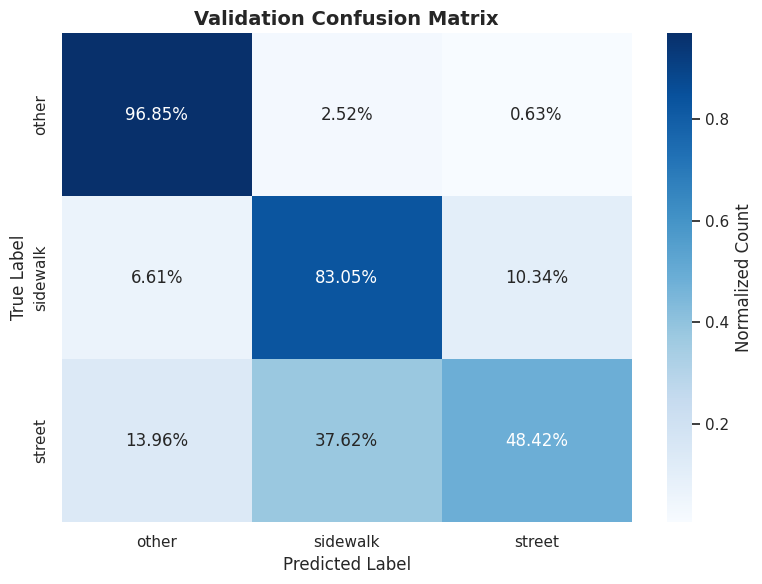


Test report
              precision    recall  f1-score   support

       other       0.90      0.98      0.94     34476
    sidewalk       0.89      0.36      0.51     34476
      street       0.64      0.96      0.77     34476

    accuracy                           0.77    103428
   macro avg       0.81      0.77      0.74    103428
weighted avg       0.81      0.77      0.74    103428



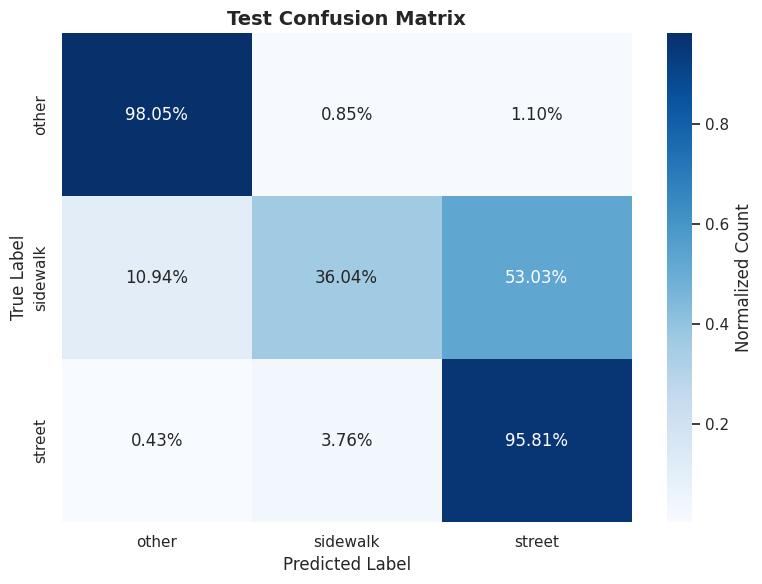

In [5]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix

# =============================
# Runtime / experiment controls
# =============================
RANDOM_SEED = 42
N_SAMPLE_POINTS = 100_000_000   # Set None to use all points, or an int (e.g., 100_000)
RF_N_JOBS = 40               # Set -1 for all cores, or a positive int for fixed cores

# Tile/grid controls
n_tiles_x = 4
n_tiles_y = 4

# Tile split ratios (must sum to 1.0)
train_ratio = 0.65
val_ratio = 0.175
test_ratio = 0.175

ratio_sum = train_ratio + val_ratio + test_ratio
if not np.isclose(ratio_sum, 1.0):
    raise ValueError(f"Split ratios must sum to 1.0, got {ratio_sum}")

if RF_N_JOBS == 0 or RF_N_JOBS < -1:
    raise ValueError("RF_N_JOBS must be -1 or a positive integer")

# Optional point sampling for faster test runs
if N_SAMPLE_POINTS is None or N_SAMPLE_POINTS >= len(df):
    df_work = df.copy()
    print(f"Using full dataset: {len(df_work):,} points")
elif N_SAMPLE_POINTS <= 0:
    raise ValueError("N_SAMPLE_POINTS must be None or a positive integer")
else:
    df_work = df.sample(n=N_SAMPLE_POINTS, random_state=RANDOM_SEED).copy()
    print(f"Sampled dataset: {len(df_work):,} / {len(df):,} points")

# Build a 4x4 grid of tiles based on X/Y extents
min_x, max_x = df_work['X'].min(), df_work['X'].max()
min_y, max_y = df_work['Y'].min(), df_work['Y'].max()
tile_size_x = (max_x - min_x) / n_tiles_x
tile_size_y = (max_y - min_y) / n_tiles_y

tile_x = np.floor((df_work['X'] - min_x) / tile_size_x).astype(int)
tile_y = np.floor((df_work['Y'] - min_y) / tile_size_y).astype(int)
tile_x = tile_x.clip(0, n_tiles_x - 1)
tile_y = tile_y.clip(0, n_tiles_y - 1)

df_work['tile_id'] = (tile_y * n_tiles_x + tile_x).astype(int)

# Keep only tiles that contain all 3 classes (per your preference)
tile_class_counts = df_work.groupby(['tile_id', 'target']).size().unstack(fill_value=0)
eligible_tiles = tile_class_counts[(tile_class_counts > 0).all(axis=1)].index.tolist()

print(f"Total tiles: {n_tiles_x * n_tiles_y}")
print(f"Eligible tiles (all classes): {len(eligible_tiles)}")

if len(eligible_tiles) == 0:
    raise ValueError("No tiles contain all 3 classes. Consider changing sample size, tile grid, or missing-class policy.")

# Split tiles into train/val/test by count
rng = np.random.default_rng(RANDOM_SEED)
tiles = np.array(eligible_tiles)
rng.shuffle(tiles)

n_total = len(tiles)
n_train = int(round(n_total * train_ratio))
n_val = int(round(n_total * val_ratio))
n_test = n_total - n_train - n_val

train_tiles = set(tiles[:n_train])
val_tiles = set(tiles[n_train:n_train + n_val])
test_tiles = set(tiles[n_train + n_val:])

print(f"Tiles -> train: {len(train_tiles)}, val: {len(val_tiles)}, test: {len(test_tiles)}")

def balance_tile(df_tile, random_state=42):
    counts = df_tile['target'].value_counts()
    n_min = counts.min()
    balanced = df_tile.groupby('target', group_keys=False).sample(
        n=n_min,
        random_state=random_state
    )
    return balanced

def build_split(df_all, tile_ids, random_state=42):
    chunks = []
    for tid in sorted(tile_ids):
        tile_df = df_all[df_all['tile_id'] == tid]
        if tile_df.empty:
            continue
        chunks.append(balance_tile(tile_df, random_state=random_state))
    if not chunks:
        return pd.DataFrame(columns=df_all.columns)
    return pd.concat(chunks, ignore_index=True)

train_df = build_split(df_work, train_tiles, random_state=RANDOM_SEED)
val_df = build_split(df_work, val_tiles, random_state=RANDOM_SEED)
test_df = build_split(df_work, test_tiles, random_state=RANDOM_SEED)

print(f"Balanced points -> train: {len(train_df):,}, val: {len(val_df):,}, test: {len(test_df):,}")

if train_df.empty or val_df.empty or test_df.empty:
    raise ValueError("One of the splits is empty after filtering/balancing. Increase sample size or adjust tile/split settings.")

feature_cols = [
    c for c in df_work.columns
    if c not in ['classification', 'target', 'tile_id']
]

X_train = train_df[feature_cols]
y_train = train_df['target']
X_val = val_df[feature_cols]
y_val = val_df['target']
X_test = test_df[feature_cols]
y_test = test_df['target']

rf = RandomForestClassifier(
    n_estimators=200,
    n_jobs=RF_N_JOBS,
    random_state=RANDOM_SEED,
    class_weight=None,  # already balancing per tile
 )
rf.fit(X_train, y_train)

def plot_confusion_matrix(cm, classes, title='Confusion Matrix', normalize=True, figsize=(8, 6)):
    if normalize:
        cm_display = cm.astype('float') / cm.sum(axis=1, keepdims=True)
        fmt = '.2%'
        cbar_label = 'Normalized Count'
    else:
        cm_display = cm
        fmt = 'd'
        cbar_label = 'Count'

    plt.figure(figsize=figsize)
    sns.heatmap(
        cm_display,
        annot=True,
        fmt=fmt,
        cmap='Blues',
        xticklabels=classes,
        yticklabels=classes,
        cbar_kws={'label': cbar_label}
    )
    plt.title(title, fontsize=14, fontweight='bold')
    plt.ylabel('True Label', fontsize=12)
    plt.xlabel('Predicted Label', fontsize=12)
    plt.tight_layout()
    plt.show()

def evaluate_split(name, X, y, normalize=True):
    preds = rf.predict(X)
    print(f"\n{name} report")
    print(classification_report(y, preds, target_names=[label_map[i] for i in sorted(label_map)]))

    cm = confusion_matrix(y, preds, labels=sorted(label_map))
    classes = [label_map[i] for i in sorted(label_map)]
    plot_confusion_matrix(
        cm,
        classes=classes,
        title=f'{name} Confusion Matrix',
        normalize=normalize,
        figsize=(8, 6),
    )

evaluate_split("Validation", X_val, y_val, normalize=True)
evaluate_split("Test", X_test, y_test, normalize=True)

In [ ]:
# Optional: run this cell only if you want to re-plot manually from stored predictions/matrices.
# The plotting utility is now defined and used in Cell 8 during evaluation.